In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import torch


In [20]:
def load_imgs(dir_path):
    imgs = []

    for filename in os.listdir(dir_path):
        if filename.lower().endswith(('.png', '.jpg')):
            img_path = os.path.join(dir_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else: 
                print(f'failed to load: {img_path}')
    return imgs



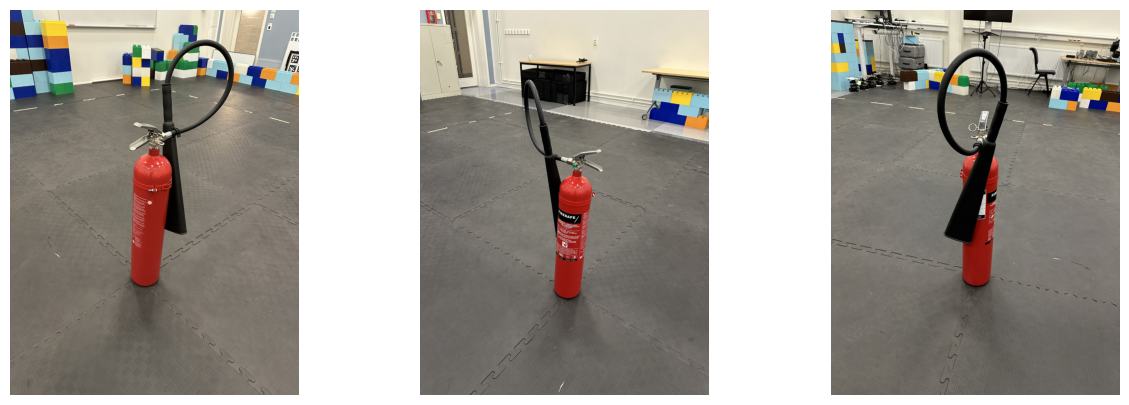

In [21]:
anchor_set = load_imgs('data/Anchor')
image_set = load_imgs('data/camera_color_image_raw')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(anchor_set[i])
    ax.axis('off')


steps:
segment object
sift on anchors



In [23]:
sift = cv2.SIFT_create()

anchors = {
    'image' : [],
    'keypoints' : [],
    'descriptors' : []
}

for anchor_img in anchor_set:
    kp, des = sift.detectAndCompute(anchor_img, None)
    anchors['image'].append(anchor_img)
    anchors['keypoints'].append(kp)
    anchors['descriptors'].append(des)



In [40]:
def draw_matches(img1, kp1, des1, img2, kp2, des2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    
    matches = bf.knnMatch(des1, des2, k=2)
    

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=4)
    

    plt.figure(figsize=(10, 10))
    plt.imshow(match_img)
    plt.axis('off')
    plt.show()

In [42]:
img1, img2, img3 = anchors['image']
kp1, kp2, kp3 = anchors['keypoints']
des1, des2, des3 = anchors['descriptors']

#draw_matches(img1, kp1, des1, img2, kp2, des2) 
#draw_matches(img1, kp1, des1, img3, kp3, des3) 
#draw_matches(img2, kp2, des2, img3, kp3, des3)

In [55]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

img = anchor_set[0]
results = model(img)

detections = results.xyxy[0].numpy()


segmented_img = img.copy()


for det in detections:
    x1, y1, x2, y2, conf, cls = det

    cv2.rectangle(segmented_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    cv2.putText(segmented_img, f'{int(cls)}: {conf:.2f}', (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cropped_img = img[int(y1):int(y2), int(x1):int(x2)]


plt.figure(figsize=(15,5))
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
cv2.imwrite('segmented.jpg', cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
cv2.imwrite('cropped.jpg', cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))



Using cache found in C:\Users\hampek/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-10-24 Python-3.11.8 torch-2.4.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\hampek/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


True